In [1]:
import numpy as np
import matplotlib.pyplot as plt


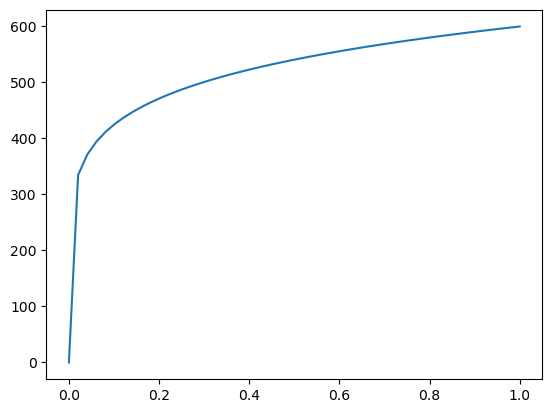

In [11]:
def compute_stress(K, n, x):
    return K * x ** n

K = 600
n = 0.15
x = np.linspace(0, 1, 50)
y = compute_stress(K, n, x)

plt.plot(x, y)

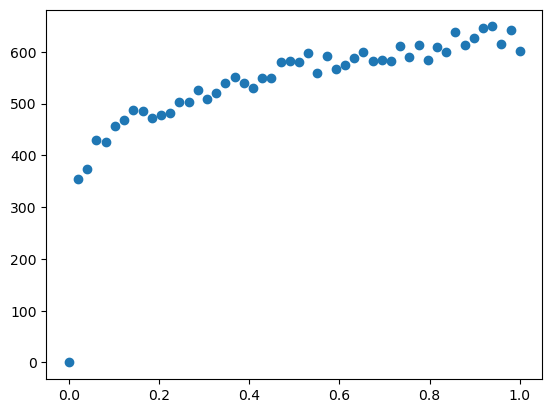

In [14]:
def generate_experimental_noisy_points(K, n, x):
    target = K * x ** n
    noise = 0.1 * np.random.random(50) * target
    return target + noise

K = 600
n = 0.15
x = np.linspace(0, 1, 50)
y_exp = generate_experimental_noisy_points(K, n, x)

plt.scatter(x, y_exp)

In [16]:
def mean_square_error(y, y_exp):
    return np.sum(np.abs(y - y_exp))

mean_square_error(y, y_exp)

1202.014690866732